**Copenhagen Business School**

*Natural Language Processing - Final Assignment 2025*

*Authors:  Eleni Kalema (Student ID: 175891), Lea Hausmann (Student ID: 176204), Stylianos Ilias Skafidas (Student ID: 175889)*

Topic: Fake News Classification, Sentiment Analysis, and Topic Modelling

In [ ]:
!pip install scikit-optimize
!pip install gensim
!pip install afinn
!pip install pyLDAvis

In [ ]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import gensim
import pyLDAvis
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from afinn import Afinn
from sentence_transformers import SentenceTransformer
from gensim import corpora, models
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import (train_test_split, GridSearchCV, RandomizedSearchCV,StratifiedKFold)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (classification_report,confusion_matrix,ConfusionMatrixDisplay,roc_curve,precision_recall_curve,auc)
from imblearn.over_sampling import SMOTE
from prettytable import PrettyTable
from collections import Counter
from sklearn.svm import SVC
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from afinn import Afinn
from nltk.stem.porter import *
from nltk.stem import PorterStemmer
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import pyLDAvis.gensim_models as gensimvis
from gensim import models
from sklearn.svm import SVC
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
from nltk.corpus import stopwords
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
import platform
import sys
import os

print("Python version:", sys.version)
print("Platform:", platform.platform())
print("System:", platform.system(), platform.release())
print("Machine:", platform.machine())
print("Processor:", platform.processor())
print("Environment Variables Sample:")
for k in list(os.environ)[:5]:
    print(f"  {k} = {os.environ[k]}")

Python version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
Platform: Linux-6.1.123+-x86_64-with-glibc2.35
System: Linux 6.1.123+
Machine: x86_64
Processor: x86_64
Environment Variables Sample:
  SHELL = /bin/bash
  NV_LIBCUBLAS_VERSION = 12.5.3.2-1
  NVIDIA_VISIBLE_DEVICES = all
  COLAB_JUPYTER_TRANSPORT = ipc
  NV_NVML_DEV_VERSION = 12.5.82-1


**Part I: Exploratory Data Analysis & Preprocessing**

*Loading the dataset*

In [ ]:
# Loading the data and bringing it to form.
paths={
    'train':'/content/drive/MyDrive/Datasets/train.tsv',
    'test':'/content/drive/MyDrive/Datasets/test.tsv',
    'valid':'/content/drive/MyDrive/Datasets/valid.tsv'}

titles=['ID','label','statement','subject','speaker','job_title','state_info','party_affiliation','barely_true_counts','false_counts','half_true_counts','mostly_true_counts','pants_on_fire_counts','context']

df=pd.DataFrame(columns=titles)
for path in paths.values():
    df_temp=pd.read_csv(path,sep='\t',header=None,names=titles)
    df=pd.concat([df,df_temp],ignore_index=True)

df.head()

<ipython-input-3-effcc8238d22>:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df=pd.concat([df,df_temp],ignore_index=True)


,ID,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Check dataset
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12791 entries, 0 to 12790
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    12791 non-null  object 
 1   label                 12791 non-null  object 
 2   statement             12791 non-null  object 
 3   subject               12789 non-null  object 
 4   speaker               12789 non-null  object 
 5   job_title             9223 non-null   object 
 6   state_info            10040 non-null  object 
 7   party_affiliation     12789 non-null  object 
 8   barely_true_counts    12789 non-null  float64
 9   false_counts          12789 non-null  float64
 10  half_true_counts      12789 non-null  float64
 11  mostly_true_counts    12789 non-null  float64
 12  pants_on_fire_counts  12789 non-null  float64
 13  context               12660 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.4+ MB
None
       barely_true

In [ ]:
# check for missing values
print(df.isnull().sum())

ID                         0
label                      0
statement                  0
subject                    2
speaker                    2
job_title               3568
state_info              2751
party_affiliation          2
barely_true_counts         2
false_counts               2
half_true_counts           2
mostly_true_counts         2
pants_on_fire_counts       2
context                  131
dtype: int64


In [ ]:
#Removing the rows that contain 2 missing values
df = df.dropna(subset=['subject', 'speaker'])
print(df.isnull().sum())

ID                         0
label                      0
statement                  0
subject                    0
speaker                    0
job_title               3566
state_info              2749
party_affiliation          0
barely_true_counts         0
false_counts               0
half_true_counts           0
mostly_true_counts         0
pants_on_fire_counts       0
context                  129
dtype: int64


In [ ]:
#Checking the percentage of the rest of the missing values
miss_perc = (df.isnull().mean() * 100).round(2)
miss_perc

,0
ID,0.00
label,0.00
statement,0.00
subject,0.00
speaker,0.00
job_title,27.88
state_info,21.50
party_affiliation,0.00
barely_true_counts,0.00
false_counts,0.00


In [ ]:
#Replacing the categorical missing values with "Unknown"
df['job_title'] = df['job_title'].fillna('Unknown')
df['state_info'] = df['state_info'].fillna('Unknown')
df['context'] = df['context'].fillna('Unknown')

<ipython-input-9-7d4d1f26e9ca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['job_title'] = df['job_title'].fillna('Unknown')
<ipython-input-9-7d4d1f26e9ca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['state_info'] = df['state_info'].fillna('Unknown')
<ipython-input-9-7d4d1f26e9ca>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [ ]:
df.isnull().sum()

,0
ID,0
label,0
statement,0
subject,0
speaker,0
job_title,0
state_info,0
party_affiliation,0
barely_true_counts,0
false_counts,0


In [ ]:
# New column: Binary classification, fake = 1, true = 0
binary_label_map = {
    'true': 0,
    'mostly-true': 0,
    'half-true': 0,
    'barely-true': 1,
    'false': 1,
    'pants-fire': 1
}


df['label_binary'] = df['label'].map(binary_label_map)


df['label_binary'].value_counts()

<ipython-input-11-8eb96156fa82>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label_binary'] = df['label'].map(binary_label_map)


,count
label_binary,
0,7134
1,5655


In [ ]:
# Boolean masking
label_mapping = {
    'pants-fire': 1,
    'false': 2,
    'barely-true': 3,
    'half-true': 4,
    'mostly-true': 5,
    'true': 6}

df['m_label'] = df['label'].replace(label_mapping)

<ipython-input-12-571492596ade>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['m_label'] = df['label'].replace(label_mapping)
<ipython-input-12-571492596ade>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['m_label'] = df['label'].replace(label_mapping)


In [ ]:
df.head()

,ID,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,label_binary,m_label
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,1,2
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,0,4
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,0,5
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,Unknown,Unknown,none,7.0,19.0,3.0,5.0,44.0,a news release,1,2
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,Unknown,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,0,4


In [ ]:
#  Changing types to proper format
df['barely_true_counts'] = df['barely_true_counts'].astype(int)
df['false_counts'] = df['false_counts'].astype(int)
df['half_true_counts'] = df['half_true_counts'].astype(int)
df['mostly_true_counts'] = df['mostly_true_counts'].astype(int)
df['pants_on_fire_counts'] = df['pants_on_fire_counts'].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12789 entries, 0 to 12790
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    12789 non-null  object
 1   label                 12789 non-null  object
 2   statement             12789 non-null  object
 3   subject               12789 non-null  object
 4   speaker               12789 non-null  object
 5   job_title             12789 non-null  object
 6   state_info            12789 non-null  object
 7   party_affiliation     12789 non-null  object
 8   barely_true_counts    12789 non-null  int64 
 9   false_counts          12789 non-null  int64 
 10  half_true_counts      12789 non-null  int64 
 11  mostly_true_counts    12789 non-null  int64 
 12  pants_on_fire_counts  12789 non-null  int64 
 13  context               12789 non-null  object
 14  label_binary          12789 non-null  int64 
 15  m_label               12789 non-null  int

In [ ]:
# Checking party affiliation distribution
df['party_affiliation'].value_counts()

,count
party_affiliation,
republican,5665
democrat,4137
none,2181
organization,264
independent,180
newsmaker,64
libertarian,51
journalist,49
activist,45


In [ ]:
# Replacing 'none' with 'no affiliation' & dropping rest values
df['party_affiliation'].unique()

df.drop(df[df['party_affiliation'].isin(['democrat','republican','none'])==False].index, inplace=True)

df['party_affiliation'] = df['party_affiliation'].replace('none', 'no affiliation')

(array([0, 1, 2]),
 [Text(0, 0, 'republican'),
  Text(1, 0, 'democrat'),
  Text(2, 0, 'no affiliation')])

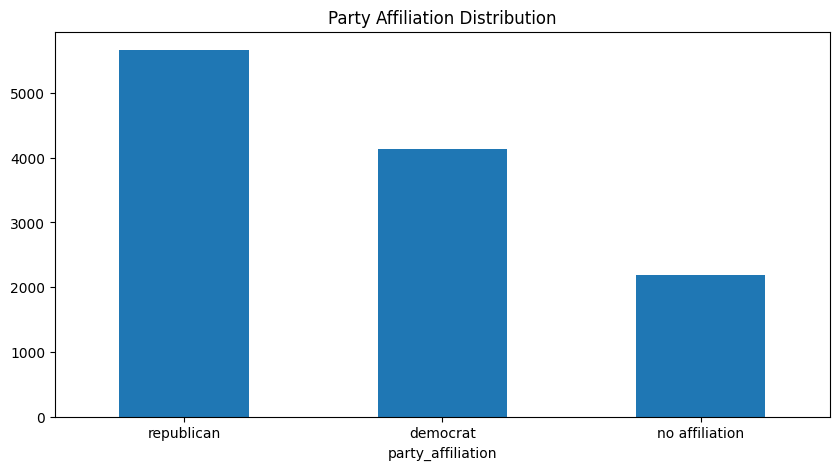

In [ ]:
#Checking if the 'party_affiliation' changes worked
df['party_affiliation'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('Party Affiliation Distribution')
plt.xticks(rotation=0)

Text(0, 0.5, 'Count')

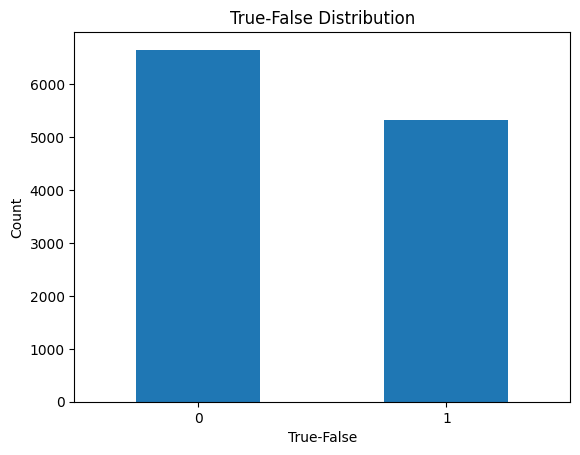

In [ ]:
df['label_binary'].value_counts().plot(kind='bar')
plt.title('True-False Distribution')
plt.xticks(rotation=0, ha='center')
plt.xlabel('True-False')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

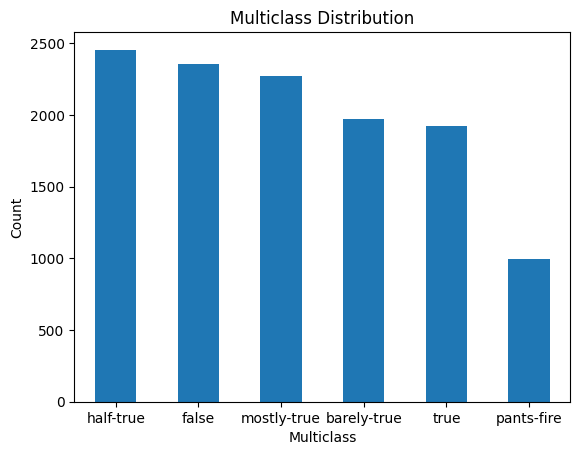

In [ ]:
df['label'].value_counts().plot(kind='bar')
plt.title('Multiclass Distribution')
plt.xticks(rotation=0, ha='center')
plt.xlabel('Multiclass')
plt.ylabel('Count')

In [ ]:
# Checking length of statements
df['statement'].str.len().describe()

,statement
count,11983.000000
mean,107.037553
std,64.471012
min,11.000000
25%,73.000000
50%,98.000000
75%,133.000000
max,3192.000000


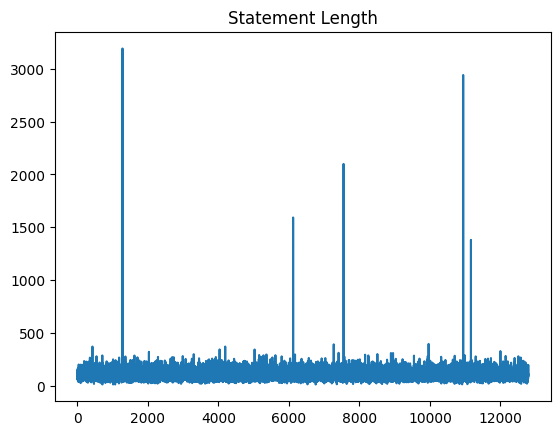

In [ ]:
statement_length = df['statement'].apply(len)
statement_length.plot()
plt.title("Statement Length")
plt.show()

In [ ]:
# Clearing outliers
Q1 = statement_length.quantile(0.25)
Q3 = statement_length.quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR

df = df[statement_length < upper_bound]
statement_length = statement_length[statement_length < upper_bound]

statement_length.describe()

,statement
count,11783.000000
mean,103.742001
std,41.282072
min,11.000000
25%,73.000000
50%,98.000000
75%,131.000000
max,222.000000


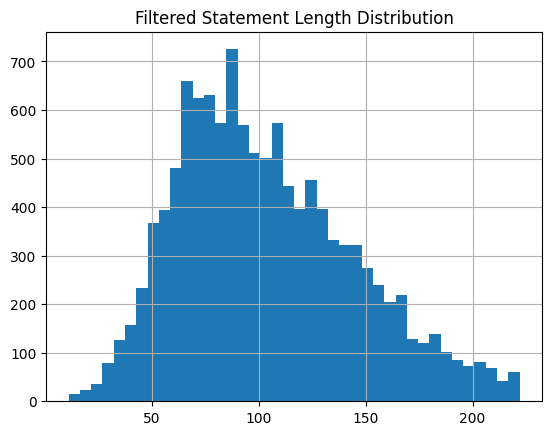

In [ ]:
statement_length.hist(bins=40)
plt.title("Filtered Statement Length Distribution")
plt.show()

In [ ]:
df['speaker'].value_counts()

,count
speaker,
barack-obama,606
donald-trump,339
hillary-clinton,289
mitt-romney,211
john-mccain,187
...,...
burger-king,1
paul-babeu,1
kal-penn,1


<Axes: ylabel='job_title'>

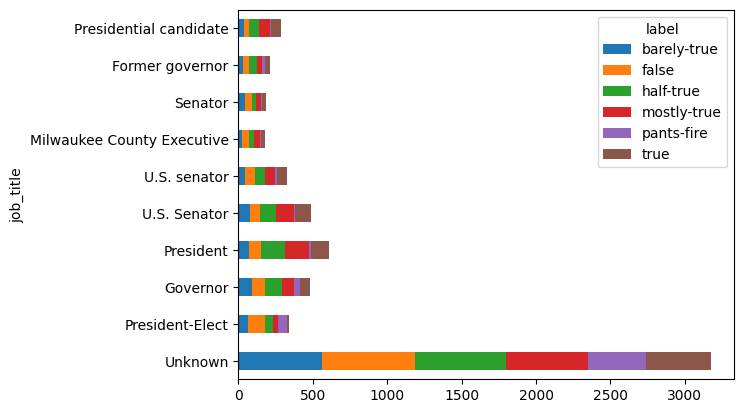

In [ ]:
pd.crosstab(df['job_title'], df['label']).sort_values(by='false', ascending=False).head(10).plot(kind='barh', stacked=True)

<Axes: ylabel='job_title'>

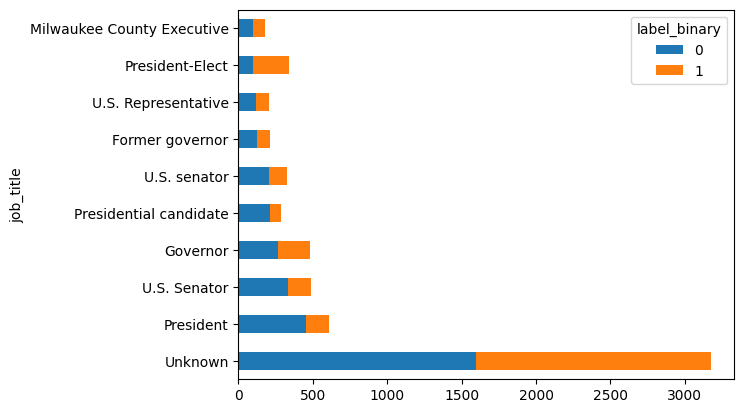

In [ ]:
pd.crosstab(df['job_title'], df['label_binary']).sort_values(by=0, ascending=False).head(10).plot(kind='barh', stacked=True)

<Axes: title={'center': 'Party-wise Label Distribution'}, xlabel='party_affiliation'>

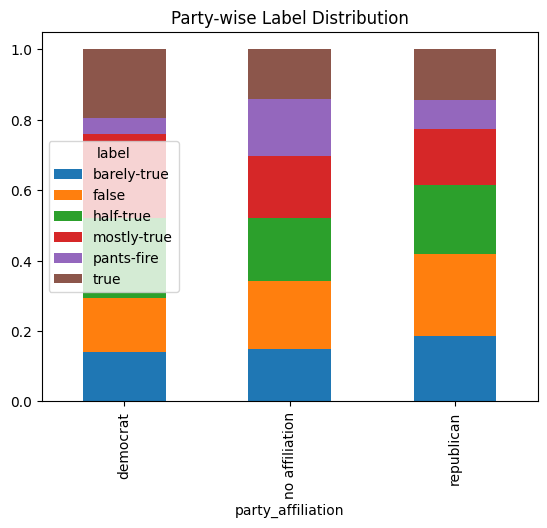

In [ ]:
df.groupby('party_affiliation')['label'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, title='Party-wise Label Distribution')


<Axes: title={'center': 'Party-wise Label Distribution'}, xlabel='party_affiliation'>

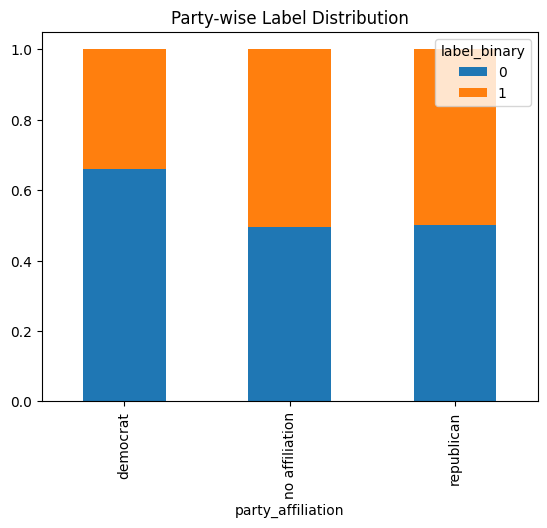

In [ ]:
df.groupby('party_affiliation')['label_binary'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, title='Party-wise Label Distribution')

In [ ]:
#speaker credibility ratio
df['total_hist'] = df[['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']].sum(axis=1)
df['fake_ratio'] = (df['half_true_counts'] + df['false_counts'] + df['pants_on_fire_counts']) / df['total_hist']
df['real_ratio'] = 1 - df['fake_ratio']

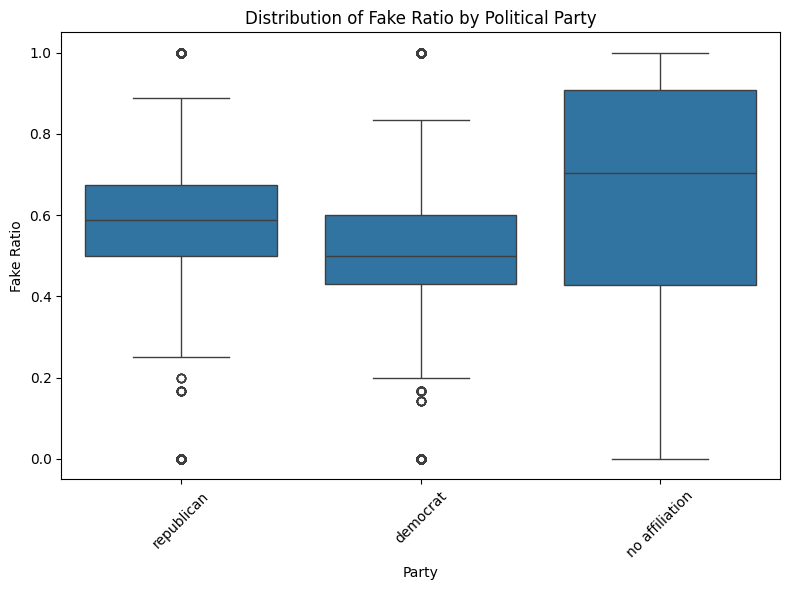

In [ ]:
#box plot of fake ratio by political party
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='party_affiliation', y='fake_ratio')
plt.title('Distribution of Fake Ratio by Political Party')
plt.xlabel('Party')
plt.ylabel('Fake Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

*Text preprocessing*

In [ ]:
# Creating df2 so it doesn't affect the original df
# tokenize, tokenize, lowercase, remove stop words
stop_words = set(stopwords.words('english'))
custom_punctuations = set(string.punctuation) | {"``", "''", "“", "”", "‘", "’", "`", "–", "—", "...", "…"}

df2=df.copy()
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Lowercase
    tokens = [token.lower() for token in tokens]
    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
    tokens=[token for token in tokens if token not in custom_punctuations]
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    # Join tokens back into a single string
    return ' '.join(tokens)

df2['processed_text'] = df2['statement'].apply(preprocess_text)
df2.head()

,ID,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,label_binary,m_label,total_hist,fake_ratio,real_ratio,processed_text
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0,0,0,a mailer,1,2,1,1.000000,0.000000,says annies list political group supports thir...
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,a floor speech.,0,4,2,0.500000,0.500000,decline coal start started natural gas took st...
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70,71,160,163,9,Denver,0,5,473,0.507400,0.492600,hillary clinton agrees john mccain voting give...
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,Unknown,Unknown,no affiliation,7,19,3,5,44,a news release,1,2,78,0.846154,0.153846,health care reform legislation likely mandate ...
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,Unknown,Florida,democrat,15,9,20,19,2,an interview on CNN,0,4,65,0.476923,0.523077,economic turnaround started end term


In [ ]:
df2[['statement', 'processed_text']].head()

,statement,processed_text
0,Says the Annies List political group supports ...,says annies list political group supports thir...
1,When did the decline of coal start? It started...,decline coal start started natural gas took st...
2,"Hillary Clinton agrees with John McCain ""by vo...",hillary clinton agrees john mccain voting give...
3,Health care reform legislation is likely to ma...,health care reform legislation likely mandate ...
4,The economic turnaround started at the end of ...,economic turnaround started end term


In [ ]:
all_words = ' '.join(df2['processed_text']).split()
word_counts = Counter(all_words)
top20=word_counts.most_common(30)
table= PrettyTable(['Word','Count'])
for word,count in top20:
    table.add_row([word,count])
print(table)

+------------+-------+
|    Word    | Count |
+------------+-------+
|    says    |  2759 |
|  percent   |  1316 |
|   state    |  905  |
|   obama    |  878  |
|    tax     |  750  |
|   health   |  720  |
|   years    |  698  |
| president  |  684  |
|   people   |  652  |
|    year    |  617  |
|    care    |  612  |
|   states   |  606  |
|   would    |  603  |
|  million   |  576  |
|    jobs    |  575  |
|    new     |  533  |
|    one     |  515  |
|    bill    |  470  |
|   texas    |  455  |
|    u.s.    |  439  |
|    said    |  437  |
|  federal   |  433  |
|  billion   |  430  |
|   barack   |  427  |
|   every    |  421  |
|   voted    |  418  |
|   taxes    |  406  |
|   since    |  404  |
|   budget   |  392  |
| government |  375  |
+------------+-------+


In [ ]:
#dropping unnecessary columns
df2.drop(['ID', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'total_hist', 'fake_ratio',
        'real_ratio', 'label'], axis=1, inplace=True)

In [ ]:
df2.columns

Index(['statement', 'subject', 'speaker', 'job_title', 'state_info',
       'party_affiliation', 'context', 'label_binary', 'm_label',
       'processed_text'],
      dtype='object')

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11783 entries, 0 to 12790
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   statement          11783 non-null  object
 1   subject            11783 non-null  object
 2   speaker            11783 non-null  object
 3   job_title          11783 non-null  object
 4   state_info         11783 non-null  object
 5   party_affiliation  11783 non-null  object
 6   context            11783 non-null  object
 7   label_binary       11783 non-null  int64 
 8   m_label            11783 non-null  int64 
 9   processed_text     11783 non-null  object
dtypes: int64(2), object(8)
memory usage: 1012.6+ KB


**Part II: Models**

**Binary Classification**

Logistic Regression

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df2['processed_text'])
y = df2['label_binary']

#Data slpit
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1764, stratify=y_temp, random_state=42)

Best Parameters: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
Best Score: 0.5768646646164262
              precision    recall  f1-score   support

           0       0.66      0.58      0.62       980
           1       0.54      0.62      0.58       787

    accuracy                           0.60      1767
   macro avg       0.60      0.60      0.60      1767
weighted avg       0.61      0.60      0.60      1767



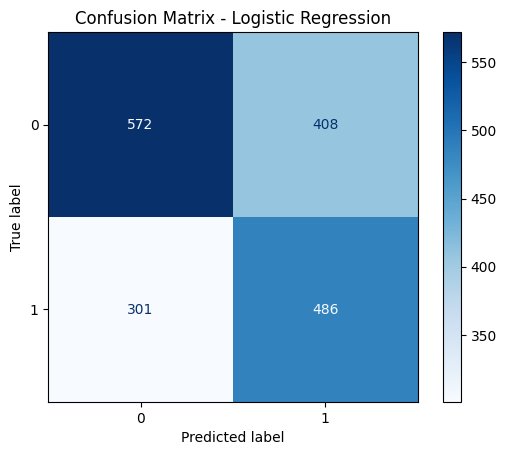

In [ ]:
# Logistic Regression + TF-IDF + balanced class weight
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],               # Regularization strength
    'penalty': ['l2'],                          # Regularization type (L2 is standard)
    'solver': ['liblinear', 'lbfgs'],           # Optimization algorithm
    'class_weight': ['balanced', None]          # To test if weighting helps
}

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='f1')

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)

# evaluate on validation set
best_lr = grid.best_estimator_
y_pred_tfidf = best_lr.predict(X_val)
print(classification_report(y_val, y_pred_tfidf))

# plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_tfidf, cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.grid(False)
plt.show()

#22sec

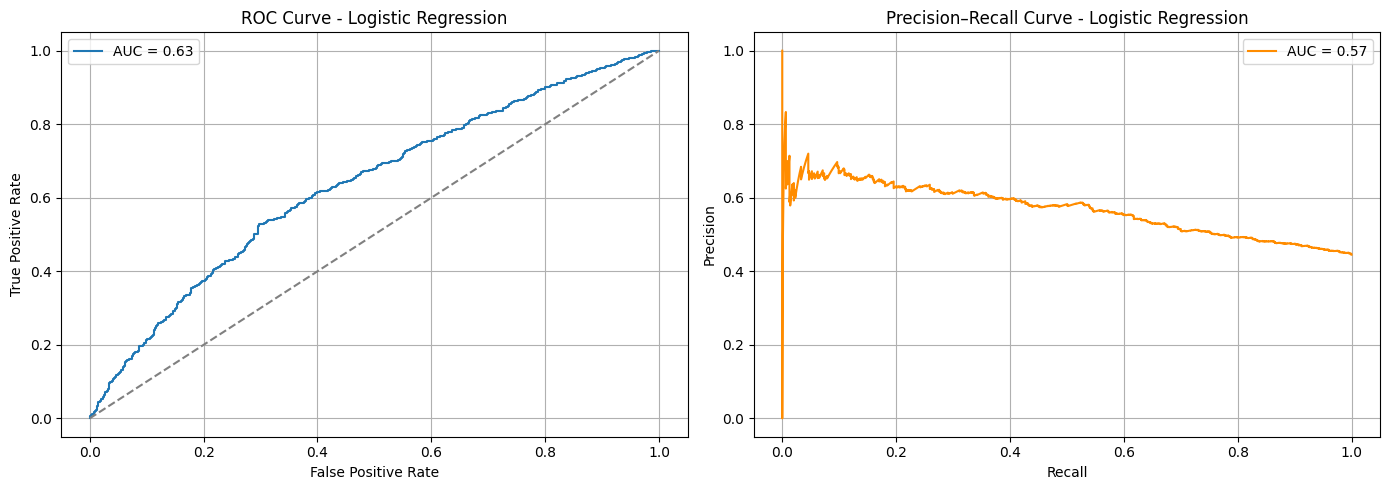

In [ ]:
# ROC and Precision-Recall curves
y_score = best_lr.predict_proba(X_val)[:, 1]


fpr, tpr, _ = roc_curve(y_val, y_score)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_val, y_score)
pr_auc = auc(recall, precision)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
axs[0].plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
axs[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axs[0].set_title("ROC Curve - Logistic Regression")
axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")
axs[0].legend()
axs[0].grid(True)

# PR Curve
axs[1].plot(recall, precision, label=f"AUC = {pr_auc:.2f}", color="darkorange")
axs[1].set_title("Precision–Recall Curve - Logistic Regression")
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
#Checking if  conversion to vectors was successful
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df2['processed_text'].tolist(), show_progress_bar=True)
print(embeddings.shape)
print(embeddings[:5])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

(11783, 384)
[[-0.02201767 -0.08139203 -0.03858556 ... -0.06572504  0.16294818
   0.03166716]
 [ 0.00765    -0.01540704  0.05590824 ... -0.01523158 -0.01203235
   0.00256724]
 [ 0.01385154  0.00411285 -0.03936072 ...  0.03489301  0.06549983
  -0.07342093]
 [-0.05731876  0.06322437  0.02000517 ... -0.14666931  0.07835375
  -0.08146842]
 [-0.03054913 -0.01889845  0.07523321 ... -0.10288235  0.01611033
   0.09649183]]


In [ ]:
X = embeddings  # SBERT embeddings
y = df2['label_binary']  # using binary labels


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1764, stratify=y_temp, random_state=42)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuned Logistic Regression
Best Parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.65      0.59      0.62       980
           1       0.54      0.60      0.57       787

    accuracy                           0.60      1767
   macro avg       0.59      0.60      0.59      1767
weighted avg       0.60      0.60      0.60      1767



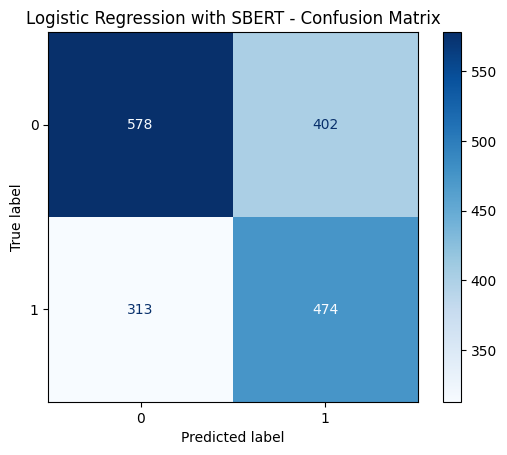

In [ ]:
# Logistic regression + SBERT + balanced class weight

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs'],
    'class_weight': ['balanced', None]
}

logreg_cv = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid,
    cv=StratifiedKFold(n_splits=5),
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

logreg_cv.fit(X_train, y_train)
best_logreg = logreg_cv.best_estimator_

print("Tuned Logistic Regression")
print("Best Parameters:", logreg_cv.best_params_)

# test on validation set
y_pred_sbert = best_logreg.predict(X_val)
print(classification_report(y_val, y_pred_sbert))
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_sbert, cmap="Blues")
plt.title("Logistic Regression with SBERT - Confusion Matrix")
plt.show()

#29 secs


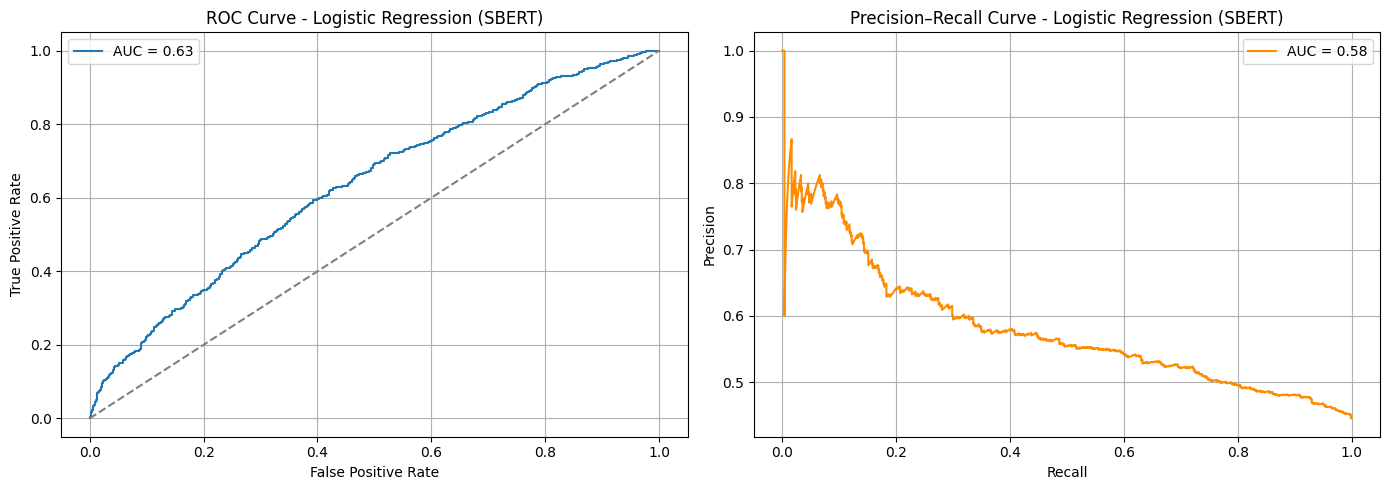

In [ ]:
# ROC & PR curves
y_score = best_logreg.predict_proba(X_val)[:, 1]


fpr, tpr, _ = roc_curve(y_val, y_score)
roc_auc = auc(fpr, tpr)


precision, recall, _ = precision_recall_curve(y_val, y_score)
pr_auc = auc(recall, precision)


fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# ROC
axs[0].plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
axs[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axs[0].set_title("ROC Curve - Logistic Regression (SBERT)")
axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")
axs[0].legend()
axs[0].grid(True)

# PR
axs[1].plot(recall, precision, label=f"AUC = {pr_auc:.2f}", color="darkorange")
axs[1].set_title("Precision–Recall Curve - Logistic Regression (SBERT)")
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

Multilayer Perceptron

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Tuned MLP Classifier (TF-IDF) - RandomizedSearchCV
Best Parameters: {'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'activation': 'relu'}
              precision    recall  f1-score   support

           0       0.59      0.90      0.71       980
           1       0.64      0.24      0.34       787

    accuracy                           0.60      1767
   macro avg       0.62      0.57      0.53      1767
weighted avg       0.62      0.60      0.55      1767



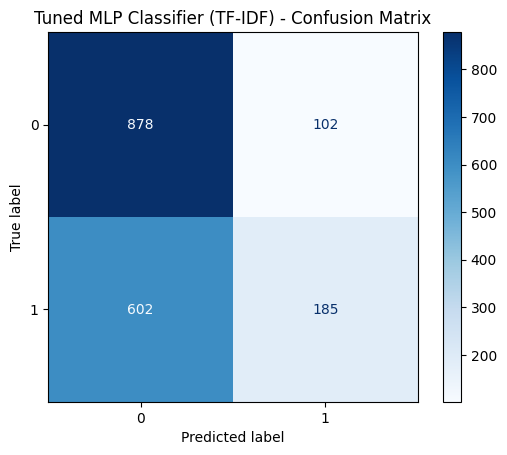

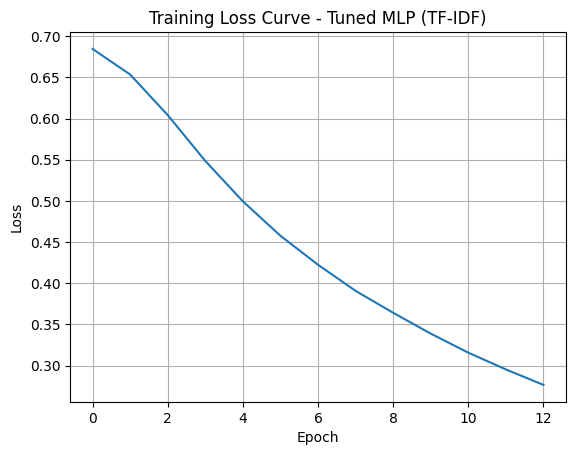

In [ ]:
# MLP + TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df2['processed_text'])
y = df2['label_binary']


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1764, stratify=y_temp, random_state=42)

# Hyperparameter search space for RandomizedSearch
mlp_param_dist = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['relu'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}

mlp_cv_tfidf = RandomizedSearchCV(
    MLPClassifier(max_iter=300, early_stopping=True, random_state=42),
    param_distributions=mlp_param_dist,
    n_iter=6,
    cv=StratifiedKFold(n_splits=5),
    scoring='f1',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

mlp_cv_tfidf.fit(X_train, y_train)
best_mlp_tfidf = mlp_cv_tfidf.best_estimator_

# Evaluation
print("Tuned MLP Classifier (TF-IDF) - RandomizedSearchCV")
print("Best Parameters:", mlp_cv_tfidf.best_params_)

y_pred_mlp_tfidf = best_mlp_tfidf.predict(X_val)
print(classification_report(y_val, y_pred_mlp_tfidf))

ConfusionMatrixDisplay.from_predictions(y_val, y_pred_mlp_tfidf, cmap="Blues")
plt.title("Tuned MLP Classifier (TF-IDF) - Confusion Matrix")
plt.show()

# Loss curve
if hasattr(best_mlp_tfidf, 'loss_curve_'):
    plt.plot(best_mlp_tfidf.loss_curve_)
    plt.title("Training Loss Curve - Tuned MLP (TF-IDF)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

#1 min

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Tuned MLP Classifier with SMOTE
Best Parameters: {'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'activation': 'tanh'}
              precision    recall  f1-score   support

           0       0.61      0.59      0.60       980
           1       0.51      0.53      0.52       787

    accuracy                           0.56      1767
   macro avg       0.56      0.56      0.56      1767
weighted avg       0.56      0.56      0.56      1767



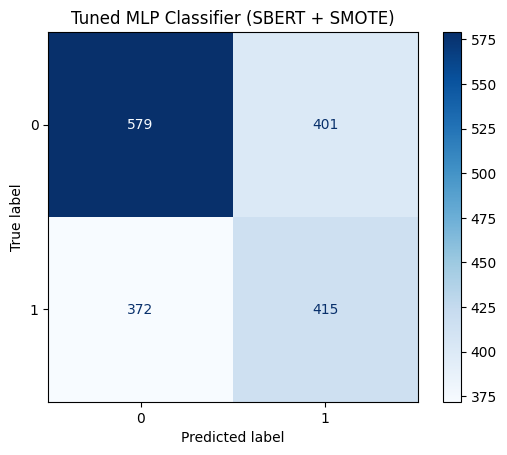

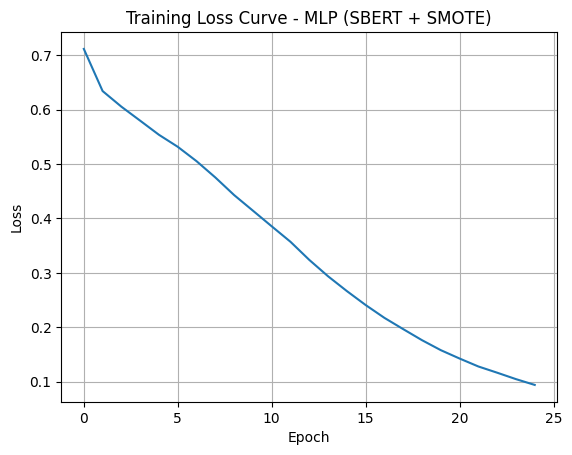

In [ ]:
# MLP + SBERT with scaled embeddings + SMOTE

scaler = StandardScaler()
X_scaled = scaler.fit_transform(embeddings)

X = X_scaled
y = df2['label_binary']


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1764, stratify=y_temp, random_state=42)

# SMOTE oversampling on training set
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# MLP hyperparameter space
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['relu','tanh'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}


mlp_cv = RandomizedSearchCV(
    MLPClassifier(max_iter=300, early_stopping=True, random_state=42),
    mlp_params,
    cv=StratifiedKFold(n_splits=5),
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

# Fit on SMOTE-balanced data
mlp_cv.fit(X_train_resampled, y_train_resampled)
best_mlp = mlp_cv.best_estimator_

# Evaluate on validation set
print("Tuned MLP Classifier with SMOTE")
print("Best Parameters:", mlp_cv.best_params_)

y_pred_mlp_cv = best_mlp.predict(X_val)
print(classification_report(y_val, y_pred_mlp_cv))

ConfusionMatrixDisplay.from_predictions(y_val, y_pred_mlp_cv, cmap="Blues")
plt.title("Tuned MLP Classifier (SBERT + SMOTE)")
plt.show()

# Loss curve
if hasattr(best_mlp, 'loss_curve_'):
    plt.plot(best_mlp.loss_curve_)
    plt.title("Training Loss Curve - MLP (SBERT + SMOTE)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

#60 sec

Standard Vector Machine

In [ ]:
# Data split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(embeddings)
X = X_scaled
y = df2['label_binary']


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1764, stratify=y_temp, random_state=42)

In [ ]:
# Basic SVM
svm = SVC(kernel='linear', class_weight='balanced', C=1.0,random_state=42)
svm.fit(X_train, y_train)

print(classification_report(y_test, svm.predict(X_test)))

#4 minutes

              precision    recall  f1-score   support

           0       0.65      0.63      0.64       980
           1       0.56      0.59      0.57       788

    accuracy                           0.61      1768
   macro avg       0.61      0.61      0.61      1768
weighted avg       0.61      0.61      0.61      1768



In [ ]:
# Basic SVM with Smote
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


svm = SVC(kernel='linear', class_weight='balanced', C=1.0, random_state=42)
svm.fit(X_train_resampled, y_train_resampled)

print(classification_report(y_test, svm.predict(X_test)))
#6 min

              precision    recall  f1-score   support

           0       0.65      0.64      0.65       980
           1       0.56      0.57      0.57       788

    accuracy                           0.61      1768
   macro avg       0.61      0.61      0.61      1768
weighted avg       0.61      0.61      0.61      1768



In [ ]:
# Grid searching for parameters

param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.01, 0.1, 1, 10],
    'class_weight': [None, 'balanced'],
    'gamma': ['scale', 'auto']}

svm = SVC()
grid = GridSearchCV(svm, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train, y_train)

print(grid.best_params_)

{'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
#  Optimized SVM
print(classification_report(y_test, grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67       980
           1       0.59      0.59      0.59       788

    accuracy                           0.63      1768
   macro avg       0.63      0.63      0.63      1768
weighted avg       0.63      0.63      0.63      1768



In [ ]:
# Optimized SVM with Smote
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

svm = SVC(kernel='rbf', class_weight='balanced', C=1.0, random_state=42, gamma='scale')
svm.fit(X_train_resampled, y_train_resampled)

print(classification_report(y_test, svm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.64      0.73      0.68       980
           1       0.60      0.49      0.54       788

    accuracy                           0.62      1768
   macro avg       0.62      0.61      0.61      1768
weighted avg       0.62      0.62      0.62      1768



**Multiclass Classification**

Logistic Regression

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

Logistic Regression (TF-IDF)
Best Params: {'C': 1, 'class_weight': 'balanced', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           1       0.19      0.32      0.24       148
           2       0.26      0.23      0.25       349
           3       0.23      0.22      0.23       290
           4       0.25      0.20      0.22       360
           5       0.26      0.25      0.26       336
           6       0.26      0.29      0.27       284

    accuracy                           0.24      1767
   macro avg       0.24      0.25      0.24      1767
weighted avg       0.25      0.24      0.24      1767



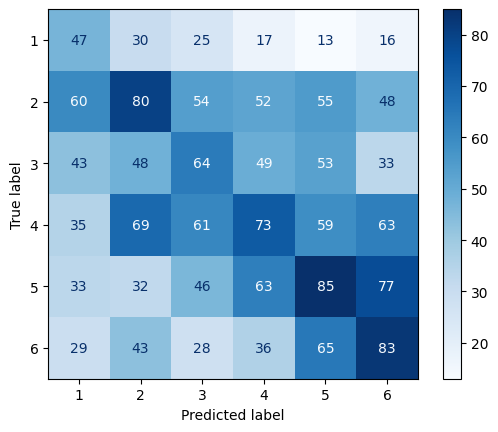

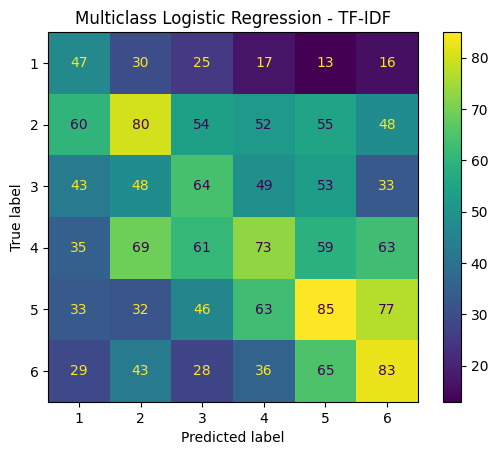

In [ ]:
# TF-IDF + Logistic Regression + balanced class weight
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df2['processed_text'])
y_multi = df2['m_label']


X_temp, X_test, y_temp, y_test = train_test_split(
    X_tfidf, y_multi, test_size=0.15, stratify=y_multi, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1764, stratify=y_temp, random_state=42)

lr_params = {'C': [0.1, 1, 10], 'solver': ['lbfgs'], 'class_weight': ['balanced']}

lr_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, multi_class='multinomial'),
    param_grid=lr_params,
    cv=5,
    scoring='f1_macro'
)
lr_grid.fit(X_train, y_train)
lr_best = lr_grid.best_estimator_
y_pred_lr = lr_best.predict(X_val)
y_score_lr = lr_best.predict_proba(X_val)

print("Logistic Regression (TF-IDF)")
print("Best Params:", lr_grid.best_params_)
print(classification_report(y_val, y_pred_lr))
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_lr, cmap="Blues").plot()
plt.title("Multiclass Logistic Regression - TF-IDF")
plt.show()




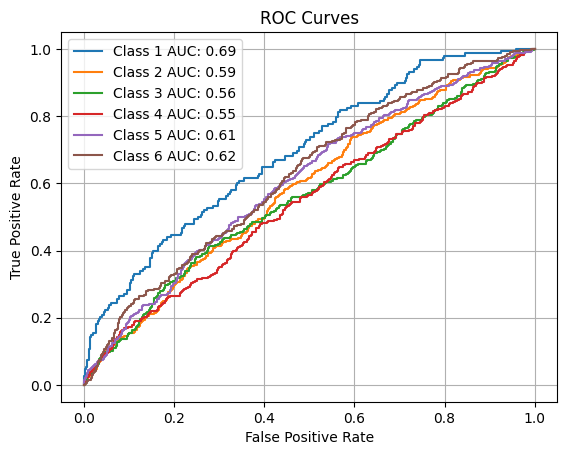

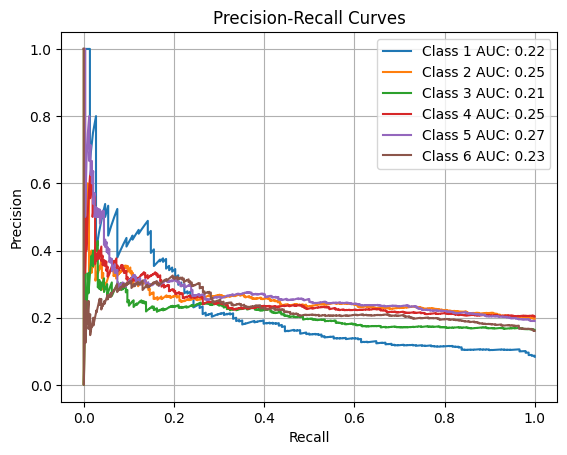

In [ ]:
# Plot ROC curves
plt.figure()
for cls in lr_best.classes_:
    cls_index = np.where(lr_best.classes_ == cls)[0][0]
    fpr, tpr, _ = roc_curve(y_val == cls, y_score_lr[:, cls_index])
    plt.plot(fpr, tpr, label=f"Class {cls} AUC: {auc(fpr, tpr):.2f}")
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)

# Plot Precision-Recall curves
plt.figure()
for cls in lr_best.classes_:
    cls_index = np.where(lr_best.classes_ == cls)[0][0]
    prec, rec, _ = precision_recall_curve(y_val == cls, y_score_lr[:, cls_index])
    plt.plot(rec, prec, label=f"Class {cls} AUC: {auc(rec, prec):.2f}")
plt.title("Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)

Batches:   0%|          | 0/369 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

Logistic Regression (SBERT)
              precision    recall  f1-score   support

           1       0.17      0.39      0.24       148
           2       0.27      0.20      0.23       349
           3       0.24      0.23      0.24       290
           4       0.24      0.17      0.20       360
           5       0.28      0.23      0.25       336
           6       0.24      0.30      0.27       284

    accuracy                           0.24      1767
   macro avg       0.24      0.26      0.24      1767
weighted avg       0.25      0.24      0.24      1767



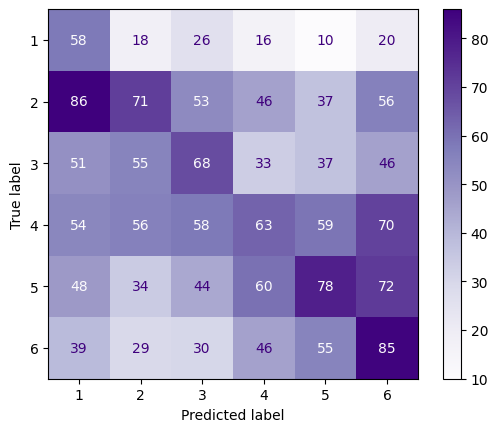

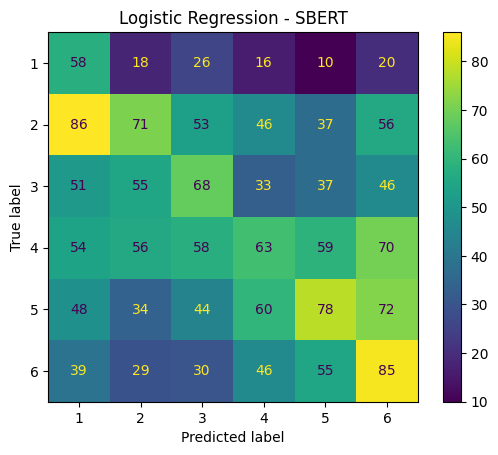

In [ ]:
# SBERT + Logistic Regression + SMOTE + GridSearchCV
model = SentenceTransformer('all-MiniLM-L6-v2')
X_embed = model.encode(df2['processed_text'].tolist(), show_progress_bar=True)

X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y_multi, test_size=0.15, stratify=y_multi, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1764, stratify=y_temp, random_state=42)
X_train_sm, y_train_sm = SMOTE(random_state=42).fit_resample(X_train, y_train)

lr_grid.fit(X_train_sm, y_train_sm)
lr_best = lr_grid.best_estimator_
y_pred_lr = lr_best.predict(X_val)

print("Logistic Regression (SBERT)")
print(classification_report(y_val, y_pred_lr))
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_lr, cmap="Purples").plot()
plt.title("Logistic Regression - SBERT")
plt.show()

Multilayer Perceptron

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=4. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 2 candidates, totalling 6 fits
MLP (TF-IDF + SMOTE)
Best Params: {'learning_rate': 'constant', 'hidden_layer_sizes': 100, 'alpha': 0.0001, 'activation': 'relu'}
              precision    recall  f1-score   support

           1       0.25      0.28      0.26       148
           2       0.25      0.24      0.25       349
           3       0.20      0.17      0.18       290
           4       0.21      0.23      0.22       360
           5       0.25      0.24      0.24       336
           6       0.22      0.24      0.23       284

    accuracy                           0.23      1767
   macro avg       0.23      0.23      0.23      1767
weighted avg       0.23      0.23      0.23      1767



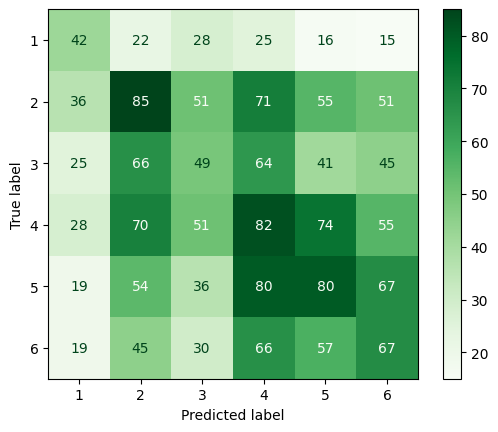

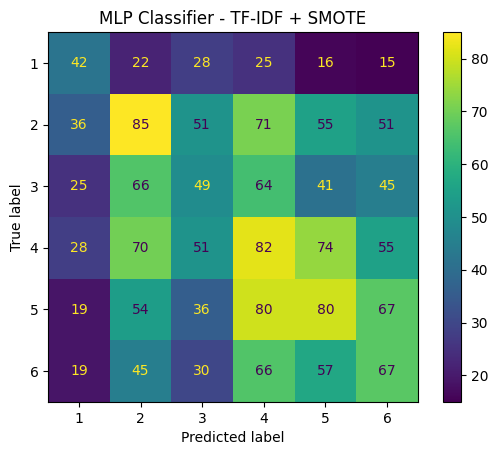

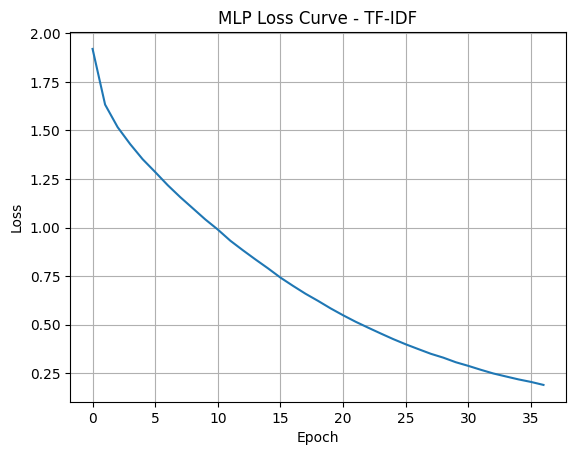

In [ ]:
# TF-IDF + MLP + SMOTE + RandomizedSearchCV
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

mlp_param_dist = {
    'hidden_layer_sizes': [(150),(100)],
    'activation': ['relu'],
    'alpha': [0.0001],
    'learning_rate': ['constant']
}

mlp_rand = RandomizedSearchCV(
    MLPClassifier(max_iter=300, early_stopping=True, random_state=42),
    param_distributions=mlp_param_dist,
    cv=3,
    scoring='f1_macro',
    n_iter=4,
    verbose=1,
    n_jobs=-1
)
mlp_rand.fit(X_train_sm, y_train_sm)
mlp_best = mlp_rand.best_estimator_
y_pred_mlp = mlp_best.predict(X_val)

print("MLP (TF-IDF + SMOTE)")
print("Best Params:", mlp_rand.best_params_)
print(classification_report(y_val, y_pred_mlp))
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_mlp, cmap="Greens").plot()
plt.title("MLP Classifier - TF-IDF + SMOTE")
plt.show()

if hasattr(mlp_best, 'loss_curve_'):
    plt.plot(mlp_best.loss_curve_)
    plt.title("MLP Loss Curve - TF-IDF")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=4. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 2 candidates, totalling 6 fits
MLP (SBERT + SMOTE)
Best Params: {'learning_rate': 'constant', 'hidden_layer_sizes': 100, 'alpha': 0.0001, 'activation': 'relu'}
              precision    recall  f1-score   support

           1       0.25      0.28      0.26       148
           2       0.25      0.24      0.25       349
           3       0.20      0.17      0.18       290
           4       0.21      0.23      0.22       360
           5       0.25      0.24      0.24       336
           6       0.22      0.24      0.23       284

    accuracy                           0.23      1767
   macro avg       0.23      0.23      0.23      1767
weighted avg       0.23      0.23      0.23      1767



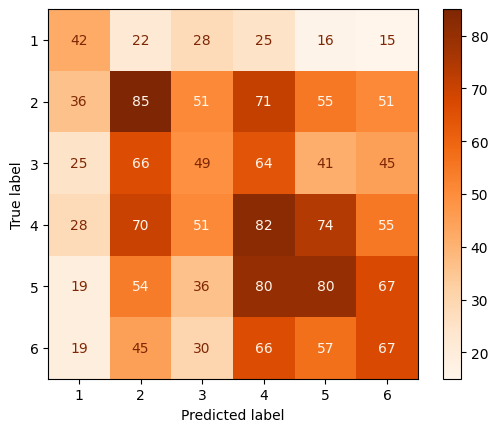

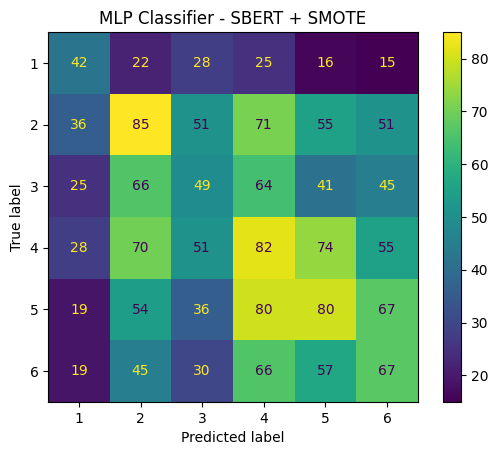

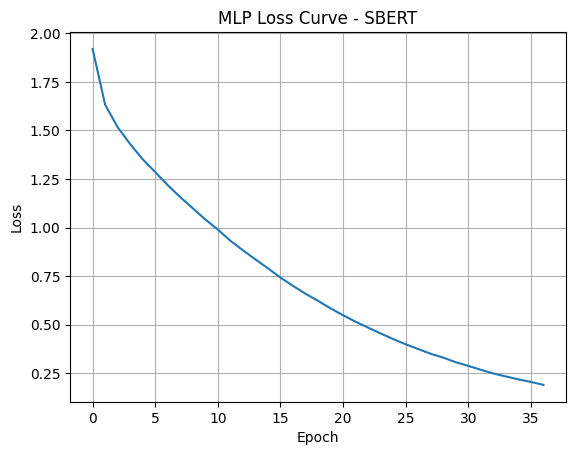

In [ ]:
# SBERT + MLP + SMOTE + RandomizedSearchCV
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_embed)

# Data split with SMOTE
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y_multi, test_size=0.15, stratify=y_multi, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1764, stratify=y_temp, random_state=42)
X_train_sm, y_train_sm = SMOTE(random_state=42).fit_resample(X_train, y_train)

mlp_rand.fit(X_train_sm, y_train_sm)
mlp_best = mlp_rand.best_estimator_
y_pred_mlp = mlp_best.predict(X_val)

print("MLP (SBERT + SMOTE)")
print("Best Params:", mlp_rand.best_params_)
print(classification_report(y_val, y_pred_mlp))
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_mlp, cmap="Oranges").plot()
plt.title("MLP Classifier - SBERT + SMOTE")
plt.show()

if hasattr(mlp_best, 'loss_curve_'):
    plt.plot(mlp_best.loss_curve_)
    plt.title("MLP Loss Curve - SBERT")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

Standard Vector Machine

In [ ]:
# Data split
X = X_scaled
y = df2['m_label']

#Data slpit
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1764, stratify=y_temp, random_state=42)

In [ ]:
from sklearn.svm import LinearSVC
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'class_weight': [None, 'balanced']}

grid = RandomizedSearchCV(
    LinearSVC(random_state=42, max_iter=10000, dual=False),
    param_distributions=param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42
)

grid.fit(X_train, y_train)

svm = grid.best_estimator_
print(classification_report(y_test, svm.predict(X_test)))

              precision    recall  f1-score   support

           1       0.25      0.10      0.14       148
           2       0.29      0.34      0.31       349
           3       0.18      0.13      0.15       291
           4       0.23      0.29      0.26       360
           5       0.26      0.29      0.27       336
           6       0.23      0.21      0.22       284

    accuracy                           0.25      1768
   macro avg       0.24      0.23      0.23      1768
weighted avg       0.24      0.25      0.24      1768



In [ ]:
# Basic SVM
svm = SVC(kernel='linear', class_weight='balanced', C=1.0, random_state=42)
svm.fit(X_train, y_train)

print(classification_report(y_test, svm.predict(X_test)))

              precision    recall  f1-score   support

           1       0.13      0.28      0.18       148
           2       0.26      0.21      0.23       349
           3       0.18      0.16      0.17       291
           4       0.23      0.21      0.22       360
           5       0.27      0.22      0.24       336
           6       0.21      0.22      0.22       284

    accuracy                           0.21      1768
   macro avg       0.21      0.22      0.21      1768
weighted avg       0.22      0.21      0.21      1768



SVM Multiclass


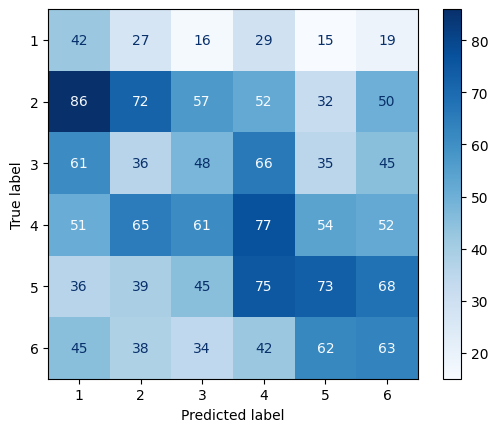

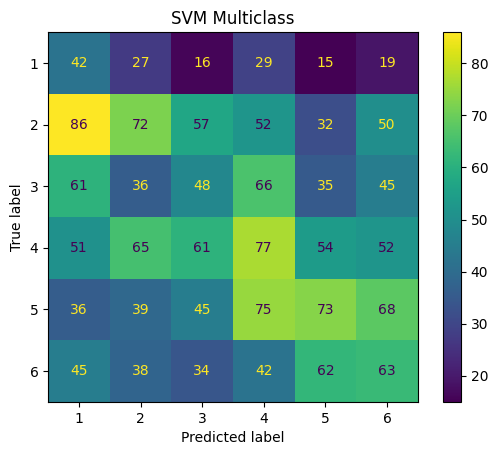

In [ ]:
print("SVM Multiclass")
y_pred_svm = svm.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, cmap="Blues").plot()
plt.title("SVM Multiclass")
plt.show()


**Part III: Sentiment Analysis**

Data Structure

In [ ]:
#Creating 'processed_context' column to clean the 'context' column and check what is the most common context out there
df2['processed_context'] = df2['context'].apply(preprocess_text)
df2.head()

,statement,subject,speaker,job_title,state_info,party_affiliation,context,label_binary,m_label,processed_text,processed_context
0,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,a mailer,1,2,says annies list political group supports thir...,mailer
1,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,a floor speech.,0,4,decline coal start started natural gas took st...,floor speech
2,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,Denver,0,5,hillary clinton agrees john mccain voting give...,denver
3,Health care reform legislation is likely to ma...,health-care,blog-posting,Unknown,Unknown,no affiliation,a news release,1,2,health care reform legislation likely mandate ...,news release
4,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,Unknown,Florida,democrat,an interview on CNN,0,4,economic turnaround started end term,interview cnn


In [ ]:
df2[['context', 'processed_context']].head()

,context,processed_context
0,a mailer,mailer
1,a floor speech.,floor speech
2,Denver,denver
3,a news release,news release
4,an interview on CNN,interview cnn


In [ ]:
# Trying to identify most suitable approach
all_words = ' '.join(df2['processed_context']).split()

word_counts = Counter(all_words)

top20=word_counts.most_common(30)
table= PrettyTable(['Word','Count'])
for word,count in top20:
    table.add_row([word,count])
print(table)

+--------------+-------+
|     Word     | Count |
+--------------+-------+
|  interview   |  1994 |
|    speech    |  1258 |
|      ad      |  1015 |
|     news     |  985  |
|   campaign   |  937  |
|    debate    |  904  |
|    press     |  819  |
|   release    |  782  |
|      's      |  675  |
|      tv      |  541  |
|     fox      |  382  |
|    radio     |  366  |
|    state     |  359  |
|  conference  |  356  |
|     post     |  354  |
|   comments   |  348  |
|  television  |  329  |
| presidential |  290  |
|  republican  |  289  |
|  statement   |  257  |
|     cnn      |  250  |
|   website    |  246  |
|    house     |  245  |
|    floor     |  241  |
|    tweet     |  237  |
|     show     |  227  |
|    video     |  221  |
|    senate    |  220  |
|     week     |  219  |
|     web      |  216  |
+--------------+-------+


VADER

In [ ]:
vdr = SentimentIntensityAnalyzer()

random_text = df2['statement']

for i, text in enumerate(random_text,start=1):
    vsa = vdr.polarity_scores(text)
    print(f"({i}) {text}\nVADER Scores: {vsa}\n")

Streaming output truncated to the last 5000 lines.
VADER Scores: {'neg': 0.0, 'neu': 0.859, 'pos': 0.141, 'compound': 0.5574}

(10118) Says President Barack Obama already passed all these Obamacare taxes. About a dozen of them hit middle-income taxpayers.
VADER Scores: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

(10119) The music industry is the biggest export from Africa after oil and gas.
VADER Scores: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

(10120) The presidents health care law raids Medicare by more than $500 billion and creates a Medicare rationing board a group of 15 unelected bureaucrats to slow the growth of Medicare spending.
VADER Scores: {'neg': 0.0, 'neu': 0.767, 'pos': 0.233, 'compound': 0.7845}

(10121) Congress used earmarks for more than 200 years.
VADER Scores: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

(10122) Venezuela is a country whose defense budget is probably 1/600th of the United States.
VADER Scores: {'neg': 0.0, 'neu': 0

In [ ]:
#Creating function that groups the vader scores
vdr = SentimentIntensityAnalyzer()

def get_sentiment_label(text):
    score = vdr.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

In [ ]:
#Assigning the vader results to new columns based on compound score. We have two columns one for preprocessed text and one for processed
df2['vader_org'] = df2['statement'].apply(get_sentiment_label)
df2['vader_pro'] = df2['processed_text'].apply(get_sentiment_label)

In [ ]:
df2['vader_org'].value_counts()

,count
vader_org,
Neutral,4160
Negative,3813
Positive,3810


In [ ]:
df2['vader_pro'].value_counts()

,count
vader_pro,
Neutral,4240
Positive,3875
Negative,3668


In [ ]:
df2.groupby(['m_label', 'vader_org']).size().unstack(fill_value=0)

vader_org,Negative,Neutral,Positive
m_label,,,
1,331,325,331
2,688,876,763
3,634,650,652
4,839,800,763
5,753,790,696
6,568,719,605


In [ ]:
df2.groupby(['label_binary', 'vader_org']).size().unstack(fill_value=0)

vader_org,Negative,Neutral,Positive
label_binary,,,
0,2160,2309,2064
1,1653,1851,1746


TextBlob

In [ ]:
def get_textblob_sentiment(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    subjectivity = analysis.sentiment.subjectivity

    if polarity > 0.05:
        sentiment = 'Positive'
    elif polarity < -0.05:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'

    return pd.Series([polarity, subjectivity, sentiment])

In [ ]:
df2[['tb_polarity', 'tb_subjectivity', 'tb_sentiment']] = df2['processed_text'].apply(get_textblob_sentiment)

In [ ]:
df2['tb_sentiment'].value_counts()

,count
tb_sentiment,
Neutral,6876
Positive,2983
Negative,1924


In [ ]:
df2.groupby(['m_label', 'tb_sentiment']).size().unstack(fill_value=0)

tb_sentiment,Negative,Neutral,Positive
m_label,,,
1,149,592,246
2,347,1432,548
3,314,1131,491
4,394,1355,653
5,413,1272,554
6,307,1094,491


In [ ]:
df2.groupby(['label_binary', 'tb_sentiment']).size().unstack(fill_value=0)

tb_sentiment,Negative,Neutral,Positive
label_binary,,,
0,1114,3721,1698
1,810,3155,1285


Afinn

In [ ]:
af = Afinn()

def get_afinn_sentiment(text):
    score = af.score(text)
    if score > 1:
        return 'Positive'
    elif score < -1:
        return 'Negative'
    else:
        return 'Neutral'

In [ ]:
df2['afinn_sentiment'] = df2['processed_text'].apply(get_afinn_sentiment)

In [ ]:
df2.groupby(['label_binary', 'afinn_sentiment']).size().unstack(fill_value=0)

afinn_sentiment,Negative,Neutral,Positive
label_binary,,,
0,1543,3847,1143
1,1137,3133,980


In [ ]:
df2.groupby(['m_label', 'afinn_sentiment']).size().unstack(fill_value=0)

afinn_sentiment,Negative,Neutral,Positive
m_label,,,
1,246,555,186
2,472,1450,405
3,419,1128,389
4,604,1363,435
5,539,1322,378
6,400,1162,330


**Part IV: Topic Modelling**

In [ ]:
# Creating a new DF incase things go wrong
dft=df2.copy()
dft['tokens']=dft['processed_text'].apply(lambda x: x.split())

In [ ]:
import spacy
stemmer = PorterStemmer()
nlp=spacy.load('en_core_web_sm')

def preprocess_text2(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Lowercase
    tokens = [token.lower() for token in tokens]
    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
    tokens = [token for token in tokens if token not in custom_punctuations]
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    # Lemmatization
    doc = nlp(" ".join(tokens))
    tokens = [token.lemma_ for token in doc]
    # Stemming
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens

dft['processed_text'] = dft['statement'].apply(preprocess_text2)
dft.head()

/usr/local/lib/python3.11/dist-packages/spacy/cli/_util.py:23: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string
/usr/local/lib/python3.11/dist-packages/weasel/util/config.py:8: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string


,statement,subject,speaker,job_title,state_info,party_affiliation,context,label_binary,m_label,processed_text,processed_context,vader_org,vader_pro,tb_polarity,tb_subjectivity,tb_sentiment,afinn_sentiment,tokens
0,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,a mailer,1,2,"[say, anni, list, polit, group, support, third...",mailer,Positive,Positive,0.0,0.1,Neutral,Neutral,"[says, annies, list, political, group, support..."
1,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,a floor speech.,0,4,"[declin, coal, start, start, natur, ga, took, ...",floor speech,Positive,Positive,0.1,0.4,Positive,Neutral,"[decline, coal, start, started, natural, gas, ..."
2,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,Denver,0,5,"[hillari, clinton, agre, john, mccain, vote, g...",denver,Positive,Positive,0.0,0.0,Neutral,Positive,"[hillary, clinton, agrees, john, mccain, votin..."
3,Health care reform legislation is likely to ma...,health-care,blog-posting,Unknown,Unknown,no affiliation,a news release,1,2,"[health, care, reform, legisl, like, mandat, f...",news release,Positive,Positive,0.2,0.9,Positive,Positive,"[health, care, reform, legislation, likely, ma..."
4,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,Unknown,Florida,democrat,an interview on CNN,0,4,"[econom, turnaround, start, end, term]",interview cnn,Neutral,Neutral,0.2,0.2,Positive,Neutral,"[economic, turnaround, started, end, term]"


Gensim

In [ ]:
# create dictionary mapping words to IDs
dictionary = Dictionary(dft['processed_text'])
corpus = [dictionary.doc2bow(text) for text in dft['processed_text']]
num_topics = 6
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=num_topics,
                     passes=10,
                     random_state=42)

for idx, topic in lda_model.print_topics(num_topics=num_topics, num_words=10):
    print(f"Topic {idx}: {topic}")

dft['topic_distribution'] = [lda_model.get_document_topics(bow) for bow in corpus]

Topic 0: 0.043*"say" + 0.018*"-" + 0.011*"immigr" + 0.011*"gov" + 0.010*"illeg" + 0.010*"scott" + 0.010*"would" + 0.010*"vote" + 0.009*"trump" + 0.009*"support"
Topic 1: 0.034*"." + 0.024*"say" + 0.023*"vote" + 0.019*"u." + 0.017*"not" + 0.016*"democrat" + 0.014*"republican" + 0.012*"senat" + 0.011*"do" + 0.009*"bill"
Topic 2: 0.061*"obama" + 0.044*"presid" + 0.035*"say" + 0.027*"barack" + 0.018*"clinton" + 0.012*"hillari" + 0.010*"-" + 0.009*"american" + 0.009*"bush" + 0.008*"re"
Topic 3: 0.029*"percent" + 0.028*"year" + 0.023*"state" + 0.019*"-" + 0.017*"job" + 0.013*"million" + 0.012*"tax" + 0.011*"rate" + 0.010*"spend" + 0.009*"billion"
Topic 4: 0.021*"say" + 0.013*"s" + 0.013*"gun" + 0.009*"not" + 0.009*"peopl" + 0.009*"court" + 0.008*"go" + 0.007*"one" + 0.007*"militari" + 0.007*"use"
Topic 5: 0.035*"health" + 0.030*"care" + 0.028*"say" + 0.023*"-" + 0.013*"law" + 0.012*"insur" + 0.012*"plan" + 0.011*"bill" + 0.009*"romney" + 0.008*"not"


In [ ]:
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

TF - IDF

In [ ]:
tfidf = models.TfidfModel(corpus)

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus, num_topics=8,
                                       id2word=dictionary, passes=2,
                                       workers=2)


In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.019*"-" + 0.016*"say" + 0.015*"obama" + 0.013*"." + 0.012*"year" + 0.010*"would" + 0.009*"tax" + 0.008*"percent" + 0.008*"health" + 0.008*"care"
Topic: 1 
Words: 0.027*"say" + 0.018*"year" + 0.016*"percent" + 0.011*"obama" + 0.009*"-" + 0.008*"democrat" + 0.008*"." + 0.008*"time" + 0.008*"job" + 0.008*"sinc"
Topic: 2 
Words: 0.028*"say" + 0.024*"-" + 0.015*"state" + 0.011*"texa" + 0.010*"job" + 0.007*"percent" + 0.007*"nation" + 0.006*"we" + 0.006*"presid" + 0.006*"wisconsin"
Topic: 3 
Words: 0.016*"say" + 0.014*"new" + 0.013*"health" + 0.012*"care" + 0.011*"-" + 0.008*"vote" + 0.008*"not" + 0.007*"secur" + 0.007*"percent" + 0.007*"want"
Topic: 4 
Words: 0.021*"-" + 0.018*"state" + 0.015*"job" + 0.014*"million" + 0.012*"say" + 0.011*"tax" + 0.010*"year" + 0.006*"lose" + 0.006*"health" + 0.006*"peopl"
Topic: 5 
Words: 0.024*"say" + 0.015*"-" + 0.010*"bill" + 0.008*"clinton" + 0.007*"take" + 0.007*"ve" + 0.007*"hillari" + 0.006*"sinc" + 0.006*"one" + 0.006*"state"
Topi

In [ ]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

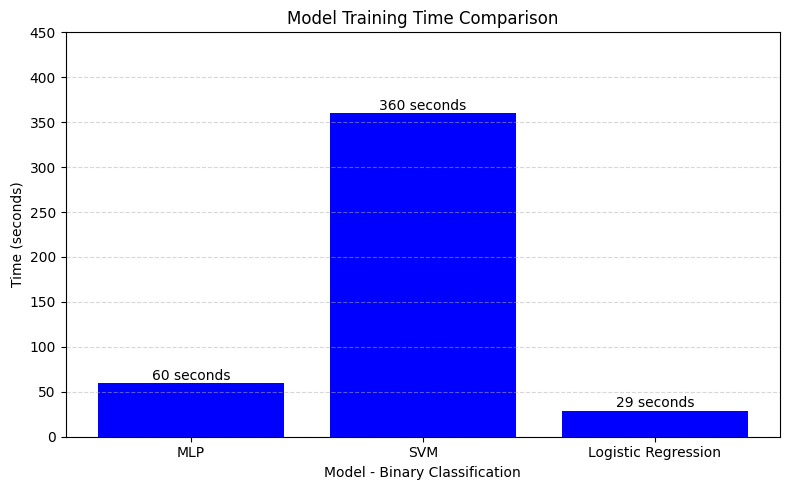

In [4]:
import matplotlib.pyplot as plt
#Time model comparison
model_names = ['MLP', 'SVM', 'Logistic Regression']
training_times = [60, 360, 29]

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, training_times, color='blue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, f'{yval} seconds', ha='center', va='bottom', fontsize=10)


plt.title('Model Training Time Comparison')
plt.ylabel('Time (seconds)')
plt.xlabel('Model - Binary Classification')
plt.ylim(0, 450)


plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
